## Plotting burnt area over time

In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
import cftime
import nc_time_axis
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *

Load in burnt area data from both observation and model

In [98]:
# Modelled: 

dir = '../outputs/model_runs/'
file = 'obs_full.nc'

cubes = iris.load_cube(dir + file, 'burnt_area')


# Observed (plus template)
dir_obs = '../outputs/'
file_obs = 'fire2000-2014_masked.nc' #_test2.nc'
template = '../data/UKESM/retrieved_codes/jul2000-jun2014/cropland_jul2000-2014.nc'

cubes_obs = iris.load_cube(dir_obs + file_obs)
cubes_temp = iris.load_cube(template)

# Save outputs:
dir_fig = '../figures/burnt_area/'

Data preparation for observed

In [99]:
fire_obs = cubes_temp
fire_obs.data = cubes_obs.data *1200 # turn into percentage
fire_obs.long_name = 'Observed burnt area (2000-2014)'

fire = cubes.copy()
fire.data = cubes.data *1200


Plot when collapsed over time 

In [81]:
iris.coord_categorisation.add_year(fire, 'time', name='year')
iris.coord_categorisation.add_year(fire_obs, 'time', name='year')

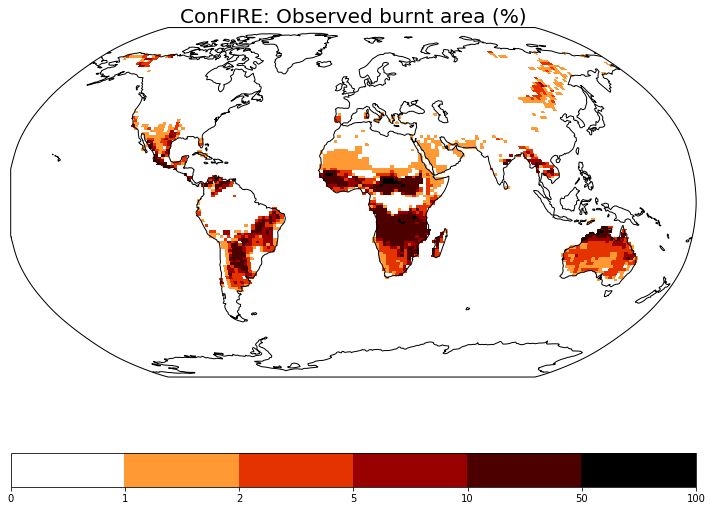

In [101]:
model_lon_lat = fire.collapsed('time', iris.analysis.MEAN)
model_lon_lat.long_name = 'ConFIRE: Observed burnt area (%)'
obs_lon_lat = fire_obs.collapsed('time', iris.analysis.MEAN)
obs_lon_lat.long_name = 'Observed burnt area (%)'


plt.figure(figsize = (10, 7.5))

plot_lonely_cube(model_lon_lat, 1, 1, 1, cmap = 'gist_heat_r', levels = [0, 1, 2, 5, 10, 50, 100])
# plot_lonely_cube(obs_lon_lat, 1, 1, 1, cmap = 'gist_heat_r', levels = [0, 1, 2, 5, 10, 50, 100])
plt.title(model_lon_lat.long_name, fontsize=20)
plt.savefig(dir_fig + 'conFIRE_obs_BA.png')

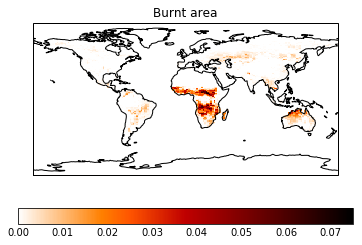

In [61]:
# iplt.contourf(obs_lon_lat, cmap = 'gist_heat_r')
# iris.quickplot.pcolormesh(obs_lon_lat, cmap = 'gist_heat_r', label = 'Averaged burnt area (%)')
# plt.title('Burnt area')
# # plt.axis('off')
# plt.gca().coastlines()

### Difference plots

In [189]:
# Observed run
dir = '../outputs/model_runs/'
file_obs = 'obs_full.nc'

# UKESM run
file_UKESM = 'full_UKESM.nc'
temp = iris.load_cube(dir + file_UKESM, 'burnt_area')

# JULES run
file_jules = 'jules_tree_veg.nc'

controls = ['fuel continuity', 'moisture content', 'ignitions', 'suppression']
def load_all_controls(file):
    def load_cube(control):
        cube = iris.load_cube(dir + file, control)
        cube = cube[:114]
        cube = cube.collapsed(['time'], iris.analysis.MEAN)
        return cube
    cubes = [load_cube(control) for control in controls]
    cubes = iris.cube.CubeList(cubes).concatenate()
    return cubes

In [190]:
cube1 = load_all_controls(file_obs)
cube2 = load_all_controls(file_UKESM)
cube3 = load_all_controls(file_jules)

In [208]:
def diff_cube(cube1, cube2, outfile):
    cube1_a = cube2[0].copy()
    cube1_a.data = cube1[0].data
    cube1_b = cube2[1].copy()
    cube1_b.data = cube1[1].data    
    cube1_c = cube2[2].copy()
    cube1_c.data = cube1[2].data    
    cube1_d = cube2[3].copy()
    cube1_d.data = cube1[3].data    
    
    plt.figure(figsize = (10, 7.5))
    plot_lonely_cube(cube2[0] - cube1_a, 2, 2, 1, cmap = 'coolwarm', levels = None)
    plt.title(cube2[0].long_name)
    plot_lonely_cube(cube2[1] - cube1_b, 2, 2, 2, cmap = 'coolwarm', levels = None)
    plt.title(cube2[1].long_name)
    plot_lonely_cube(cube2[2] - cube1_c, 2, 2, 3, cmap = 'coolwarm', levels = None)
    plt.title(cube2[2].long_name)
    plot_lonely_cube(cube2[3] - cube1_d, 2, 2, 4, cmap = 'coolwarm', levels = None)
    plt.title(cube2[3].long_name)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)
    return plt.savefig(dir_fig + outfile)

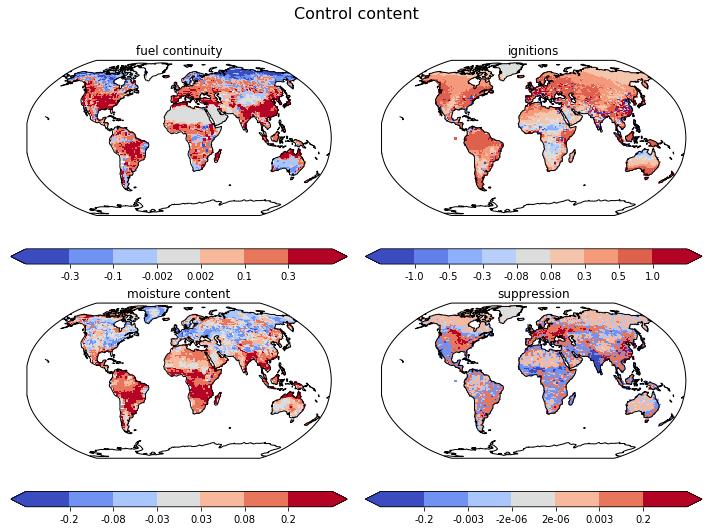

In [211]:
diff_cube(cube1, cube3, 'control_jules_obs.png')

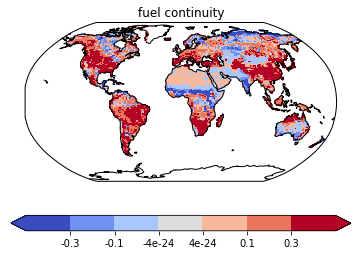

In [177]:



# c6 = c5 - c4 # UKESM v obs
# c7 = c5 - c3 # UKESM v JULES
# c8 = c3 - c4 # JULES v obs

title_output = 'Control content'

plt.figure(figsize = (10, 7.5))  
yay = cube2[0].copy()
yay.data = yay.data - cube1_r.data
plot_lonely_cube(cube2[0] - cube1[0], 2, 2, 1, cmap = 'coolwarm', levels = None)
plot_lonely_cube(cube2[1] - cube1[1], 2, 2, 2, cmap = 'coolwarm', levels = None)
plot_lonely_cube(cube2[2] - cube1[2], 2, 2, 3, cmap = 'coolwarm', levels = None)
plot_lonely_cube(cube2[3] - cube1[3], 2, 2, 4, cmap = 'coolwarm', levels = None)
plt.suptitle(title_output, fontsize=16)
plt.subplots_adjust(top=0.88)

Text(0.5,1,'Burnt Area: Difference between UKESM run and JULES vegetation run')

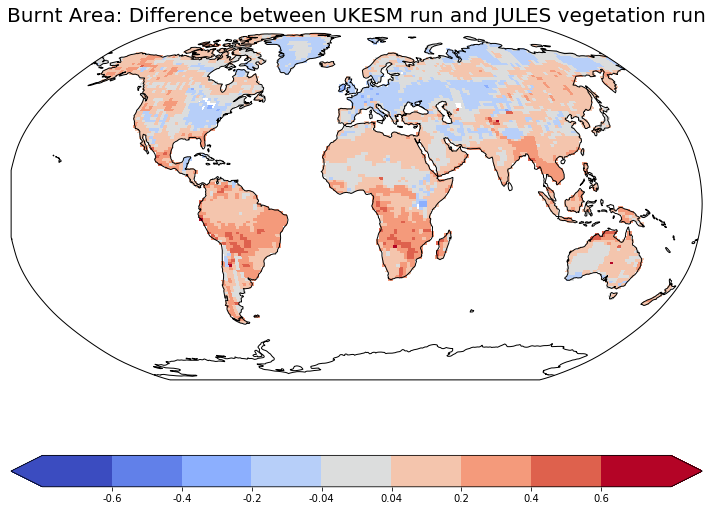

In [129]:
plt.figure(figsize = (10, 7.5))

plot_lonely_cube(c6, 1, 1, 1, cmap = 'coolwarm', levels = None) # [-0.04, -0.03, -3e-5, -2e-7, 2e-7, 3e-5, 0.03, 0.04])
plt.title('Burnt Area: Difference between UKESM run and JULES vegetation run', fontsize=20)
# plt.savefig(dir_fig + 'diff_UKESM_jules_trveg_BA.png')

### Timeline plot of modelled burnt_area

In [62]:
model_t = cubes.collapsed(['longitude','latitude'], iris.analysis.SUM)
model_yr = model_t.aggregated_by(['year'],iris.analysis.MEAN)

fire_obs.data[np.isnan(fire_obs.data)] = 0
obs_t = fire_obs.collapsed(['longitude','latitude'], iris.analysis.SUM)
obs_yr = cubes_t.aggregated_by(['year'],iris.analysis.MEAN)

NameError: name 'cubes_t' is not defined

NameError: name 'obs_yr' is not defined

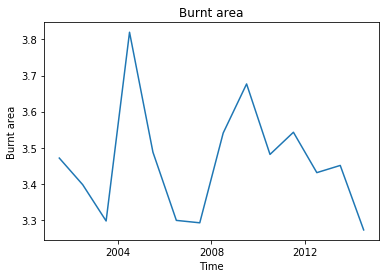

In [63]:
t_start = cftime.Datetime360Day(2000, 1, 1)
t_fin = cftime.Datetime360Day(2014, 1, 1)
xtick = [cftime.Datetime360Day(n, 1, 1) for n in range(2000, 2015, 2)]

qplt.plot(model_yr, label = 'UKESM')
qplt.plot(obs_yr, label = 'Observed')
plt.xlim(t_start, t_fin)
plt.grid(alpha = 0.3)
plt.legend(frameon = False, loc=1)
plt.title("UK-ESM and observed burnt area")
plt.ylabel("Burnt area")
# plt.xticks(xtick)

qplt.show()

Plotting observed fire

In [65]:
# Re-loading in the data
dir_obs = '../outputs/'
file_obs = 'fire2000-2014_masked_test.nc'
template = '../data/UKESM/retrieved_codes/jul2000-jun2014/cropland_jul2000-2014.nc'

cubes_temp = iris.load_cube(template)
cubes_obs = iris.load_cube(dir_obs + file_obs)

In [66]:
cubes_temp.data = cubes_obs.data

In [67]:
iris.coord_categorisation.add_year(cubes_temp, 'time', name='year')
# iris.coord_categorisation.add_month(cubes_obs, 'time', name='month')

In [68]:
# years = range(2000,2014,1)
# i = 0

# for y in years:
#     cubes_obs.coord('year').points[i:(i+12)] = y
#     i += 12
    
# cubes_obs.long_name = 'Observed burnt area'
# # print(cubes_obs.coord('year').points)
# # print(cubes_obs.data.mean)

In [69]:
canopy_t_obs = cubes_temp.collapsed(['longitude','latitude'], iris.analysis.SUM)
canopy_yr_obs = canopy_t_obs.aggregated_by(['year'],iris.analysis.MEAN)

# print(canopy_t_obs)
# print(canopy_yr_obs)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


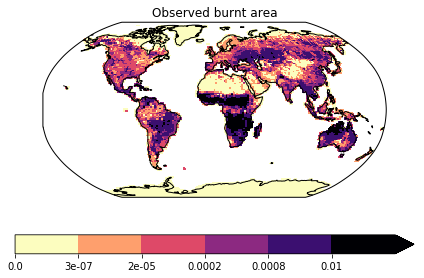

In [70]:
canopy_obs_lon_lat = cubes_temp.collapsed('time', iris.analysis.MEAN)
canopy_obs_lon_lat.long_name = 'Observed burnt area'

plot_lonely_cube(canopy_obs_lon_lat, 1, 1, 1, cmap = 'magma_r', levels = None)
print(canopy_yr_obs.data)

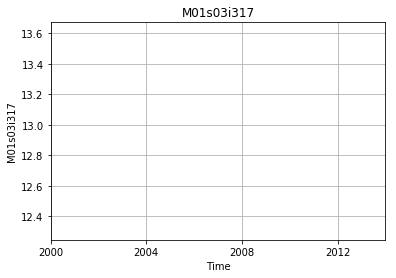

In [71]:
qplt.plot(canopy_t_obs)
plt.xlim(t_start, t_fin)
plt.grid()
# plt.xticks(xtick)

qplt.show()